In [9]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

# early stopping
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
# 데이터셋 경로 지정
train_horse_dir = "./datasets/preprocessing_noise/horse-or-human-preprocessing/horses"
train_human_dir = "./datasets/preprocessing_noise/horse-or-human-preprocessing/humans"

# 학습 데이터 리스트업
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

horse_files = [train_horse_dir + "/" + f for f in train_horse_names]
human_files = [train_human_dir + "/" + f for f in train_human_names]

In [11]:
# 모델 설계
# convolution을 16개 필터, 3*3 크기 커널
# 300*300 픽셀, RGB(3채널)
# 데이터의 깊이를 점점 높여서 레이어 형성
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            16, (3, 3), activation="relu", input_shape=(300, 300, 3)
        ),
        BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 298, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 147, 147, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 33, 33, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,450,849 (32.24 MB)

 Trainable params: 8,450,497 (32.24 MB)

 Non-trainable params: 352 (1.38 KB)

In [12]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.00001),
    metrics=["accuracy"],
)

In [13]:
# 데이터 증강을 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# 이미지 값을 0~1 사이로 제한
valid_datagen = ImageDataGenerator(rescale=1 / 255)

# train set
train_generator = train_datagen.flow_from_directory(
    "./datasets/preprocessing_noise/horse-or-human-preprocessing/",

    target_size=(300, 300),  # 해상도 조절
    batch_size=128,  # 배치 크기
    class_mode="binary",  # 분류 방법
)
# valid set
valid_generator = valid_datagen.flow_from_directory(
    "./datasets/preprocessing_noise/validation-horse-or-human-preprocessing/",
    target_size=(300, 300),

    batch_size=128,
    class_mode="binary",
)
es = EarlyStopping(

    monitor="val_loss",  # loss를 기반으로 멈추는 지점 설정
    patience=2,  # 몇 번이나 loss가 증가할 때까지 기다릴 것인가
)

# 학습 단계별로 임시 저장
checkpoint = ModelCheckpoint(

    filepath="./checkpoint.keras",

    verbose=2,  # 자세히
    save_best_only=False,  # best 결과만 저장할 것인가
    mode="auto",
)

# 모델 학습
history = model.fit(
    train_generator,

    steps_per_epoch=32,
    epochs=30,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=8,
    callbacks=[checkpoint, es],
)

Found 4108 images belonging to 2 classes.
Found 1024 images belonging to 2 classes.
Epoch 1/30
25/32 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5650 - loss: 1.0063

In [ ]:
# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - accuracy: 0.7743 - loss: 1.1364
test loss, test acc: [1.1075729131698608, 0.77734375]


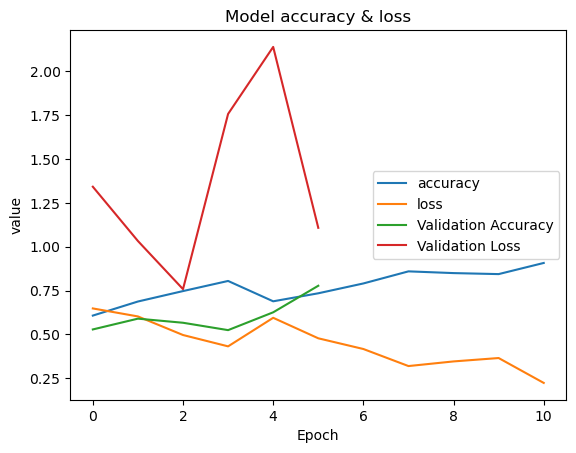

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])

plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(
    ["accuracy", "loss", "Validation Accuracy", "Validation Loss"], loc="center right"
)
plt.show()

In [ ]:
# 이미지 전처리
dlist = "./datasets/test-horse-or-human/"
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300, 300)) for i in img]
img = np.array(img)
img = img.astype("float32") / 255.0

# 분류
cutoff = 0.5
predictions = model.predict(img)
print(predictions >= cutoff)

['horse1.jpeg', 'horse2.jpeg', 'horse3.jpeg', 'human1.jpg', 'human2.jpeg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]]
